In [1]:
%load_ext autoreload
%autoreload 2
from wsidata import open_wsi
import lazyslide as zs

In [2]:
import matplotlib.pyplot as plt

In [3]:
wsi = open_wsi("data/OS-1/OS-1.vsi", reader="bioformats")
# wsi = open_wsi("data/Artery-with-holes.svs")

In [4]:
zs.pp.find_tissue(wsi)

In [ ]:
zs.pp.tile_tissue(wsi)

In [ ]:
zs.pp.tissue_qc()
zs.pp.tile_qc()

In [ ]:
zs.tl.extract_features()

In [ ]:
zs.tl.

In [23]:
zs.pp.tiles(wsi, 1000, method="polygon-test")

/Users/yzheng/miniforge3/envs/lazyslide/lib/python3.11/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `tiles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [24]:
len(wsi['tiles'])

842

In [25]:
len(wsi['tiles'].drop_duplicates(['x', 'y']))

842

In [26]:
wsi.tile_spec('tiles')

TileSpec(height=1000, width=1000, raw_height=1000, raw_width=1000, tissue_name='tissues', level=0, downsample=1, mpp=0.3460526394570825)

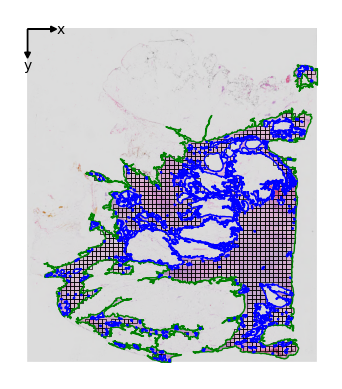

In [27]:
zs.pl.tiles(wsi, show_grid=True, show_point=False)

In [ ]:
zs.tl.feature_extraction(wsi, 'resnet50', device="mps", num_workers=2)

In [20]:
import numpy as np

In [230]:
height, width = (60, 30)
tile_h, tile_w = (11, 11)
edge = False
stride_h, stride_w = None, None

if stride_w is None:
    stride_w = tile_w
if stride_h is None:
    stride_h = tile_h

# calculate number of expected tiles
if width % stride_w == 0:
    nw = width // stride_w + 1
else:
    # If the width is not divisible by stride
    nw = width // stride_w + 1
    if edge:
        nw += 1
if height % stride_h == 0:
    nh = height // stride_h + 1
else:
    nh = height // stride_h + 1
    if edge:
        nh += 1
    
xs = np.arange(nw) * stride_w
ys = np.arange(nh) * stride_h

In [231]:
30 // 11 + 1

3

In [232]:
print(nh, nw)

6 3


In [248]:
coordinates = list()
indices = list()

xv, yv = meshgrid_numba(xs, ys)

for i in range(nw):
    for j in range(nh):
        coordinates.append([xv[j, i], yv[j, i]])

coordinates = np.asarray(coordinates)

n_rect = (nw - 1) * (nh - 1)
start_indices = np.asarray([0, 1, nh + 1, nh])
print(start_indices)
for i in range(n_rect):
    indices.append(start_indices + i)

indices = np.asarray(indices)

[0 1 7 6]


In [249]:
import numpy as np
from numba import njit

@njit
def meshgrid_numba(x, y):
    nx = x.size
    ny = y.size

    X = np.zeros((ny, nx), dtype=x.dtype)
    Y = np.zeros((ny, nx), dtype=y.dtype)

    for i in range(ny):
        for j in range(nx):
            X[i, j] = x[j]
            Y[i, j] = y[i]

    return X, Y

# Example usage:
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])
X, Y = meshgrid_numba(x, y)

tX, tY = np.meshgrid(x, y)

In [16]:
import numpy as np
from numba import njit

@njit
def create_tiles(image_shape, tile_w: int, tile_h: int, stride_w=None, stride_h=None, edge=True):
    """Create the tiles, return coordination that comprise the tiles
        and the index of points for each rectangular.

    Parameters
    ----------
    image_shape : (int, int)
        The (H, W) of the image.
    tile_w, tile_h: int
        The width/height of tiles.
    stride_w, stride_h : int, default None
        The width/height of stride when moving to the next tile.
    edge : bool, default True
        Whether to include the edge tiles.

    Returns
    -------
    coordinates : np.ndarray (N, 2)
        The coordinates of the tiles, N is the number of tiles.
    indices : np.ndarray (M, 4)
        The indices of the points for each rect, M is the number of rects.

    """
    height, width = image_shape
    if stride_w is None:
        stride_w = tile_w
    if stride_h is None:
        stride_h = tile_h

    # calculate number of expected tiles
    # If the width/height is divisible by stride
    # We need to add 1 to include the starting point
    nw = width // stride_w + 1
    nh = height // stride_h + 1

    # To include the edge tiles
    if edge and width % stride_w != 0:
        nw += 1
    if edge and height % stride_h != 0:
        nh += 1

    coordinates = list()
    indices = list()

    xs = np.arange(nw, dtype=np.uint) * stride_w
    ys = np.arange(nh, dtype=np.uint) * stride_h
    xv, yv = meshgrid(xs, ys)

    for i in range(nw):
        for j in range(nh):
            coordinates.append([xv[j, i], yv[j, i]])

    n_rect = (nw - 1) * (nh - 1)
    s1, s2, s3, s4 = 0, 1, nh + 1, nh
    for i in range(n_rect):
        indices.append([
            s1 + i, s2 + i, s3 + i, s4 + i
        ])

    return np.array(coordinates, dtype=np.uint), np.array(indices, dtype=np.uint)

@njit
def meshgrid(x, y):
    nx = x.size
    ny = y.size

    X = np.zeros((ny, nx), dtype=np.uint)
    Y = np.zeros((ny, nx), dtype=np.uint)

    for i in range(ny):
        for j in range(nx):
            X[i, j] = x[j]
            Y[i, j] = y[i]

    return X, Y

In [17]:
height, width = (60, 30)
tile_h, tile_w = (11, 11)
edge = False
stride_h, stride_w = None, None

create_tiles((height, width), tile_w, tile_h)

(array([[ 0,  0],
        [ 0, 11],
        [ 0, 22],
        [ 0, 33],
        [ 0, 44],
        [ 0, 55],
        [ 0, 66],
        [11,  0],
        [11, 11],
        [11, 22],
        [11, 33],
        [11, 44],
        [11, 55],
        [11, 66],
        [22,  0],
        [22, 11],
        [22, 22],
        [22, 33],
        [22, 44],
        [22, 55],
        [22, 66],
        [33,  0],
        [33, 11],
        [33, 22],
        [33, 33],
        [33, 44],
        [33, 55],
        [33, 66]], dtype=uint64),
 array([[ 0,  1,  8,  7],
        [ 1,  2,  9,  8],
        [ 2,  3, 10,  9],
        [ 3,  4, 11, 10],
        [ 4,  5, 12, 11],
        [ 5,  6, 13, 12],
        [ 6,  7, 14, 13],
        [ 7,  8, 15, 14],
        [ 8,  9, 16, 15],
        [ 9, 10, 17, 16],
        [10, 11, 18, 17],
        [11, 12, 19, 18],
        [12, 13, 20, 19],
        [13, 14, 21, 20],
        [14, 15, 22, 21],
        [15, 16, 23, 22],
        [16, 17, 24, 23],
        [17, 18, 25, 24]], dtype=uint6